# Assignment 6: Neural Networks

# Problem 1: The dataset

Loading the MNIST dataset from `torchvision.datasets`:

In [86]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
	root='data',
	train=True,
	download=True,
	transform=ToTensor()
)

test_data = datasets.MNIST(
	root='data',
	train=False,
	download=True,
	transform=ToTensor()
)

Wrapping the dataset in a `DataLoader`:

In [87]:
train_loader = DataLoader(
	train_data,
	batch_size=64,
)

test_loader = DataLoader(
	test_data,
	batch_size=64,
)

Plotting the first images from the training set:

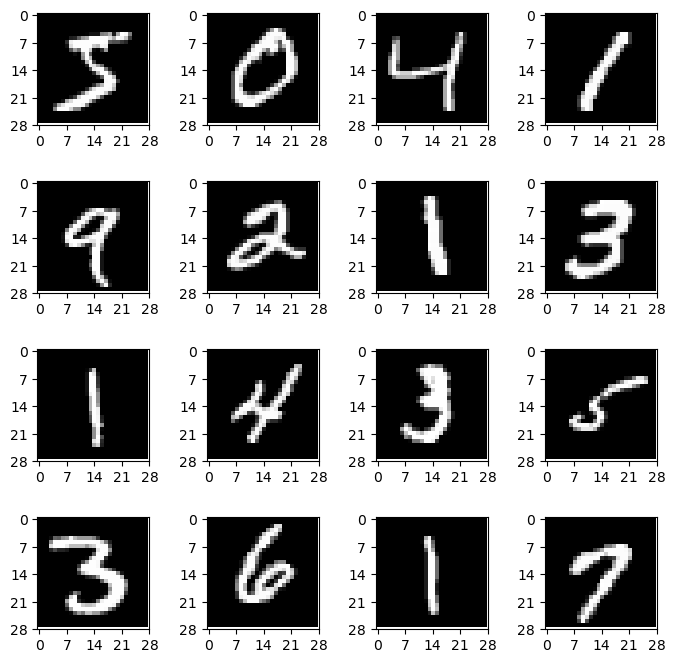

In [88]:
import matplotlib.pyplot as plt

images, _ = next(iter(train_loader))

ppr = 4  # plots per row

fig, ax = plt.subplots(
	ppr, ppr,
	figsize=(ppr * 2, ppr * 2)
)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i in range(ppr ** 2):
	ax[i // ppr, i % ppr].imshow(
		images[i].squeeze(),
		cmap='gray'
	)
	ax[i // ppr, i % ppr].set_xticks(
		range(0, 29, 7))
	ax[i // ppr, i % ppr].set_yticks(
		range(0, 29, 7))

plt.savefig('figures/mnist.png')

# Problem 2: Single hidden layer

Creating the model for a single hidden layer with ReLU activation:

In [89]:
device = (
	"cuda"
	if torch.cuda.is_available()
	else "mps"
	if torch.backends.mps.is_available()
	else "cpu"
)
print(f"Using device: {device}")

Using device: mps


In [90]:
class FNN(nn.Module):
	def __init__(self):
		super(FNN, self).__init__()
		self.flatten = nn.Flatten()
		self.linear_relu_stack = nn.Sequential(
			nn.Linear(28 * 28, 512),
			nn.ReLU(),
			nn.Linear(512, 10),
		)

	def forward(self, x):
		x = self.flatten(x)
		logits = self.linear_relu_stack(x)
		return logits


model = FNN().to(device)

Defining the training of the model using the SGD optimizer and CrossEntropy loss:

In [91]:
lr = 1e-3

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
	model.parameters(), lr=lr
)

In [92]:
def train(
		dataloader, model, loss_fn, optimizer,
		logging=True
):
	size = len(dataloader.dataset)
	model.train()
	for batch, (X, y) in enumerate(dataloader):
		X, y = X.to(device), y.to(device)

		pred = model(X)
		loss = loss_fn(pred, y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		if logging and batch % 100 == 0:
			loss, current = loss.item(), batch * len(X)
			print(
				f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]"
			)

Defining the testing of the model performance against the `test_data`:

In [93]:
def test(dataloader, model, loss_fn):
	size = len(dataloader.dataset)
	num_batches = len(dataloader)
	model.eval()
	test_loss, correct = 0, 0
	with (torch.no_grad()):
		for X, y in dataloader:
			X, y = X.to(device), y.to(device)
			pred = model(X)
			test_loss += loss_fn(pred, y).item()
			correct += (
					pred.argmax(1) == y
			).type(torch.float).sum().item()
	test_loss /= num_batches
	correct /= size
	return correct, test_loss

Training the model for 10 epochs and evaluating its performance:

In [94]:
epochs = 10

for t in range(epochs):
	print(f"epoch {t + 1}:")
	train(train_loader, model, loss_fn, optimizer)
	accuracy, test_loss = test(
		test_loader, model, loss_fn
	)
	print(f"\n accuracy: {(100 * accuracy):>0.1f}%")
	print(f" test loss: {test_loss:>8f}")
	print(f"\n-------------------------------")

epoch 1:
loss: 2.304546  [    0/60000]
loss: 2.274916  [ 6400/60000]
loss: 2.263107  [12800/60000]
loss: 2.203697  [19200/60000]
loss: 2.212941  [25600/60000]
loss: 2.208950  [32000/60000]
loss: 2.147226  [38400/60000]
loss: 2.163620  [44800/60000]
loss: 2.098763  [51200/60000]
loss: 2.061687  [57600/60000]

 accuracy: 66.3%
 test loss: 2.065312

-------------------------------
epoch 2:
loss: 2.061796  [    0/60000]
loss: 2.019906  [ 6400/60000]
loss: 2.057674  [12800/60000]
loss: 1.913586  [19200/60000]
loss: 1.946838  [25600/60000]
loss: 1.938303  [32000/60000]
loss: 1.857157  [38400/60000]
loss: 1.928552  [44800/60000]
loss: 1.807934  [51200/60000]
loss: 1.768334  [57600/60000]

 accuracy: 74.5%
 test loss: 1.756111

-------------------------------
epoch 3:
loss: 1.755741  [    0/60000]
loss: 1.685394  [ 6400/60000]
loss: 1.767269  [12800/60000]
loss: 1.565591  [19200/60000]
loss: 1.604056  [25600/60000]
loss: 1.596005  [32000/60000]
loss: 1.508044  [38400/60000]
loss: 1.638047  [44

Saving the model to a file:

In [95]:
torch.save(
	model.state_dict(),
	"models/single_layer.pth"
)
print(
	"Saved PyTorch Single Layer Model state to single_layer.pth"
)

Saved PyTorch Single Layer Model state to single_layer.pth


# Problem 3: Two hidden layers

Redeclaring the model with two hidden layers:

In [96]:
class FNN2(nn.Module):
	def __init__(self):
		super(FNN2, self).__init__()
		self.flatten = nn.Flatten()
		self.linear_relu_stack = nn.Sequential(
			nn.Linear(28 * 28, 500),
			nn.ReLU(),
			nn.Linear(500, 300),
			nn.ReLU(),
			nn.Linear(300, 10),
		)

	def forward(self, x):
		x = self.flatten(x)
		logits = self.linear_relu_stack(x)
		return logits


model = FNN2().to(device)

Redefine the optimizer with L2 regularization:

In [97]:
weight_decay = 1e-4

optimizer = torch.optim.SGD(
	model.parameters(),
	lr=0.1,
	weight_decay=weight_decay
)

Train the model for 50 epochs and evaluate its performance:

In [98]:
epochs = 50

for t in range(epochs):
	print(f"epoch {t + 1}:")
	train(train_loader, model, loss_fn, optimizer,
	      logging=False)
	accuracy, test_loss = test(
		test_loader, model, loss_fn
	)
	print(f"\n accuracy: {(100 * accuracy):>0.1f}%")
	print(f" test loss: {test_loss:>8f}")
	print(f"\n-------------------------------")

epoch 1:

 accuracy: 93.5%
 test loss: 0.217788

-------------------------------
epoch 2:

 accuracy: 95.5%
 test loss: 0.144604

-------------------------------
epoch 3:

 accuracy: 96.4%
 test loss: 0.114212

-------------------------------
epoch 4:

 accuracy: 96.9%
 test loss: 0.096418

-------------------------------
epoch 5:

 accuracy: 97.4%
 test loss: 0.084117

-------------------------------
epoch 6:

 accuracy: 97.5%
 test loss: 0.077915

-------------------------------
epoch 7:

 accuracy: 97.6%
 test loss: 0.074544

-------------------------------
epoch 8:

 accuracy: 97.7%
 test loss: 0.072433

-------------------------------
epoch 9:

 accuracy: 97.7%
 test loss: 0.070536

-------------------------------
epoch 10:

 accuracy: 97.8%
 test loss: 0.070116

-------------------------------
epoch 11:

 accuracy: 97.8%
 test loss: 0.069559

-------------------------------
epoch 12:

 accuracy: 97.8%
 test loss: 0.069514

-------------------------------
epoch 13:

 accuracy: 97.

Save the model to a file:

In [99]:
torch.save(
	model.state_dict(), "models/two_layer.pth"
)
print(
	"Saved PyTorch Two Layer Model state to two_layer.pth"
)

Saved PyTorch Two Layer Model state to two_layer.pth


# Problem 4: Convolutional Neural Network

Redeclaring the model with convolutional layers:

In [100]:
class CNN(nn.Module):
	def __init__(self):
		super(CNN, self).__init__()
		self.conv1 = nn.Conv2d(
			1, 32,
			kernel_size=3,
			stride=1,
			padding=1
		)
		self.conv2 = nn.Conv2d(
			32, 64,
			kernel_size=3,
			stride=1,
			padding=1
		)
		self.fc1 = nn.Linear(
			64 * 7 * 7,
			128
		)
		self.fc2 = nn.Linear(128, 10)

	def forward(self, x):
		x = torch.relu(self.conv1(x))
		x = torch.max_pool2d(x, 2)
		x = torch.relu(self.conv2(x))
		x = torch.max_pool2d(x, 2)
		x = x.view(-1, 64 * 7 * 7)
		x = torch.relu(self.fc1(x))
		x = self.fc2(x)
		return x


model = CNN().to(device)

Redefine the optimizer:

In [101]:
optimizer = torch.optim.SGD(
	model.parameters(),
	lr=0.01,
	weight_decay=weight_decay
)

Train the model for 40 epochs and evaluate its performance:

In [102]:
epochs = 40

for t in range(epochs):
	print(f"epoch {t + 1}:")
	train(train_loader, model, loss_fn, optimizer,
		logging=False)
	accuracy, test_loss = test(
		test_loader, model, loss_fn
	)
	print(f"\n accuracy: {(100 * accuracy):>0.1f}%")
	print(f" test loss: {test_loss:>8f}")
	print(f"\n-------------------------------")


epoch 1:

 accuracy: 89.3%
 test loss: 0.347669

-------------------------------
epoch 2:

 accuracy: 92.6%
 test loss: 0.238393

-------------------------------
epoch 3:

 accuracy: 94.2%
 test loss: 0.176060

-------------------------------
epoch 4:

 accuracy: 95.5%
 test loss: 0.139001

-------------------------------
epoch 5:

 accuracy: 96.3%
 test loss: 0.116188

-------------------------------
epoch 6:

 accuracy: 96.8%
 test loss: 0.100557

-------------------------------
epoch 7:

 accuracy: 97.1%
 test loss: 0.090778

-------------------------------
epoch 8:

 accuracy: 97.3%
 test loss: 0.083569

-------------------------------
epoch 9:

 accuracy: 97.5%
 test loss: 0.077472

-------------------------------
epoch 10:

 accuracy: 97.7%
 test loss: 0.072438

-------------------------------
epoch 11:

 accuracy: 97.9%
 test loss: 0.067642

-------------------------------
epoch 12:

 accuracy: 97.9%
 test loss: 0.064028

-------------------------------
epoch 13:

 accuracy: 98.

Save the model to a file:

In [103]:
torch.save(model.state_dict(), "models/cnn.pth")
print("Saved PyTorch CNN Model state to cnn.pth")

Saved PyTorch CNN Model state to cnn.pth
